# Magnetic Field Calculator for Generic Wire Configurations
### Adam Jaros

In [240]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as const
import tqdm
import pandas as pd
import matplotlib.colors
import matplotlib.patches as patches
import pickle
from scipy.optimize import curve_fit

%matplotlib widget

Specify the size and resolution of the space that the magnetic field should be analyzed over.

Can replace linspace with custom array of points if desired. (such as for slices)

In [241]:
bounding_box = 0.2 # meters
resolution = 100 # number of points per axis (total number of points is resolution^3)

x = np.linspace(-bounding_box, bounding_box, resolution)
y = np.linspace(-bounding_box, bounding_box, resolution)
z = np.linspace(-bounding_box, bounding_box, resolution)

x,y,z = np.meshgrid(x,y,[0])

In [242]:
# specify the center and radius
center_x = 0.0
center_y = 0.0
center_z = 0.0
radius = 0.02008
z_dist = 0.2

# specify resolution
angle_resolution = 15  # number of points on the ring
z_resolution = 100  # number of points on the z axis

# calculate the angles for each point
theta = np.linspace(0, 2*np.pi, angle_resolution, endpoint=False)

# generate the points on the ring
x = center_x + radius * np.cos(theta)
y = center_y + radius * np.sin(theta)

# for z, just create a single valued array
z = np.linspace(center_z - z_dist/2, center_z + z_dist/2, z_resolution)

# create a meshgrid-like array for the cylinder points
x = np.tile(x, (z_resolution, 1))
y = np.tile(y, (z_resolution, 1))
z = np.tile(z, (angle_resolution, 1)).T

# add extra dimension
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)
z = np.expand_dims(z, axis=1)

In [243]:
print(theta * 180 / np.pi)

[  0.  24.  48.  72.  96. 120. 144. 168. 192. 216. 240. 264. 288. 312.
 336.]


In [244]:
x.shape, y.shape, z.shape

((100, 1, 15), (100, 1, 15), (100, 1, 15))

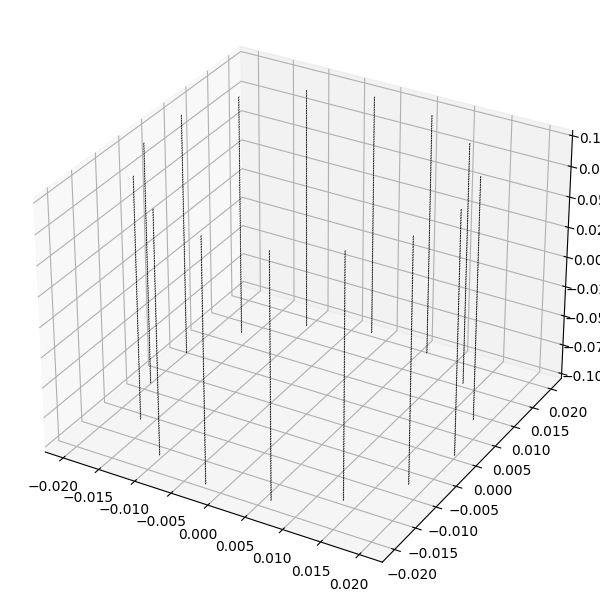

In [245]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0, 0, 1, 1], projection='3d', auto_add_to_figure=False)

ax.quiver(x,y,z,np.ones_like(x),np.zeros_like(y),np.zeros_like(z), length=0.0001, normalize=True, color='k', arrow_length_ratio=0.1)

Field calculated using Biot-Savart Law.

In [246]:
def calc_field(x,y,z,wire_segments):
    field = np.zeros((x.shape[0], y.shape[1], z.shape[2], 3))
    global pbar
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            for k in range(z.shape[2]):
                r = np.array([x[i,j,k], y[i,j,k], z[i,j,k]]) - wire_segments[:,0] # position vector from point to wire segment
                
                dl = wire_segments[:,1] # wire segment vector

                r_mag = np.linalg.norm(r, axis=1) # magnitude of r

                # skip if any r_mag is close to zero (too close to wire segment)
                if np.any(r_mag < 1e-3):
                    pbar.update(1)
                else:
                    field[i,j,k] = np.sum(np.cross(dl, r) / (r_mag**3)[:, np.newaxis], axis=0) # calculate field from wire segment
                    pbar.update(1)
                
    mu0 = 4 * np.pi * 1e-7
    field *= mu0 / 4 / np.pi # convert to tesla (T)
    return field

In [247]:
# Calculate field
with open('wire_segments.pkl', 'rb') as f:
    wire_segments = pickle.load(f)

print('Calculating Field...')
print(x.shape[0] * y.shape[1] * z.shape[2], 'space points')
print(wire_segments.shape[0], 'wire points') 
pbar = tqdm.tqdm(total=x.shape[0]*y.shape[1]*z.shape[2])

field = calc_field(x, y, z, wire_segments)

pbar.close()

field *= 5.5 * 1e4 # convert to gauss (G)

Calculating Field...
1500 space points
448768 wire points


  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [03:43<00:00,  6.71it/s]


In [248]:
def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# min res for full details: 25r 4theta 20z
rv, thetav, zv = np.mgrid[0.03:0.1:25j, 0:np.pi*2:33j, -0.05:0.05:20j]
xv = rv*np.cos(thetav)
yv = rv*np.sin(thetav)

rc, thetac, zc = midpoints(rv), midpoints(thetav), midpoints(zv)

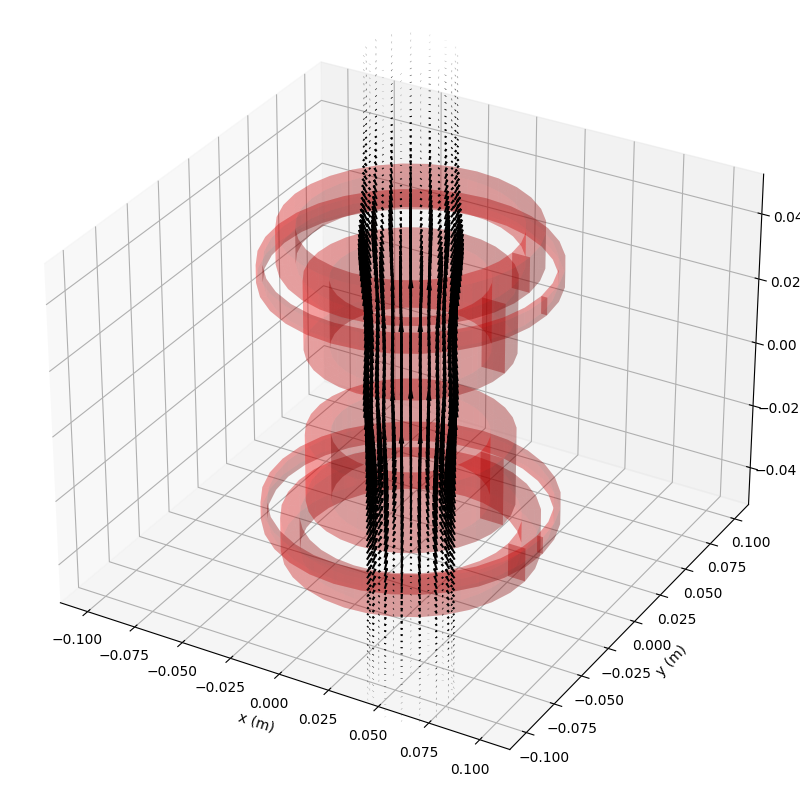

In [265]:
# Plot field and wire in 3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0, 0, 1, 1], projection='3d', auto_add_to_figure=False)

field_strength = np.linalg.norm(field, axis=3)
ax.quiver(x, y, z, field[:,:,:,0], field[:,:,:,1], field[:,:,:,2], normalize=False, length=5e-6, color='k')#, normalize=True) #, color=c) # full field vectors

# define the bounds for each solenoid in the setup
in_solenoids = (rc > 0.0366) * (rc < 0.0469) * (zc**2 > 0.0140**2) * (zc**2 < 0.0359**2)
in_shields1 = (rc > 0.0505) * (rc < 0.0591) * (zc**2 > 0.0404**2) * (zc**2 < 0.0511**2)
in_shields2 = (rc > 0.065) * (rc < 0.0679) * (zc**2 > 0.0359**2) * (zc**2 < 0.0417**2)
voxels = in_solenoids + in_shields1 + in_shields2
ax.voxels(xv, yv, zv, voxels, linewidth=0.5, alpha=0.2, facecolors='red', edgecolors=None);

#plt.plot(np.cos(np.linspace(0,math.tau, 100)), np.sin(np.linspace(0,math.tau, 100)), np.zeros(100), color='r', linewidth=1)

ax.set_xlabel('x (m)'); ax.set_ylabel('y (m)'); ax.set_zlabel('z (m)');

In [250]:
# plot field strength along z-axis
#fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111)
#ax.plot(z[0,0,:], field[field.shape[0]//2,field.shape[1]//2,:,2])
#ax.set_xlabel('z (m)')
#ax.set_ylabel('B (G)');
#ax.set_title('Field strength along z-axis')

print('Max Field Strength:', max(field[field.shape[0]//2,field.shape[1]//2,:,2]), 'G')
print('Location of Max Field Strength:', z[0,0,np.argmax(field[field.shape[0]//2,field.shape[1]//2,:,2])], 'm')

Max Field Strength: 1756.6036130135612 G
Location of Max Field Strength: -0.1 m


In [251]:
# plot theta vs. total field strength
#fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111)

#ax.plot(theta, field[0,0,:,0], label='x')
#ax.plot(theta, field[0,0,:,1], label='y')

r = np.array([x - center_x, y - center_y, np.zeros_like(z)]) # position vector from center to point
r_mag = np.sqrt(r[0,0,0,:]**2 + r[1,0,0,:]**2 + r[2,0,0,:]**2)
r_norm = r / r_mag

field_r = field[:,:,:,0]*r_norm[0,:,:,:] + field[:,:,:,1]*r_norm[1,:,:,:] + field[:,:,:,2]*r_norm[2,:,:,:]
field_r = field_r.flatten()

tan = np.array([np.cross(r_norm[:,0,0,i], np.array([0,0,1])) for i in range(r.shape[3])])
tan_mag = np.sqrt(tan[:,0]**2 + tan[:,1]**2 + tan[:,2]**2)
r_tan = tan / tan_mag[:, np.newaxis]
field_tan = field[:,:,:,0]*r_tan[:,0] + field[:,:,:,1]*r_tan[:,1] + field[:,:,:,2]*r_tan[:,2]
field_tan = field_tan.flatten()

field_mag = np.sqrt(field[:,:,:,0]** 2 + field[:,:,:,1]** 2 + field[:,:,:,2]** 2)
field_mag = field_mag.flatten()

field_z = field[:,:,:,2].flatten()

#ax.plot(theta, field_r, label='$B_r$')
#ax.plot(theta, field_tan, label='$B_\\varphi$')
#ax.plot(theta, field_mag, label='$B$')
#ax.plot(theta, field_z, label='$B_z$')

#ax.set_xlabel('theta (rad)')
#ax.set_ylabel('B (G)');
#ax.set_title('Field strength vs. theta')
#ax.legend();

output_file = [field, field_r, field_tan, field_z]
with open('measure_test.pkl', 'wb') as f:
    pickle.dump(output_file, f)


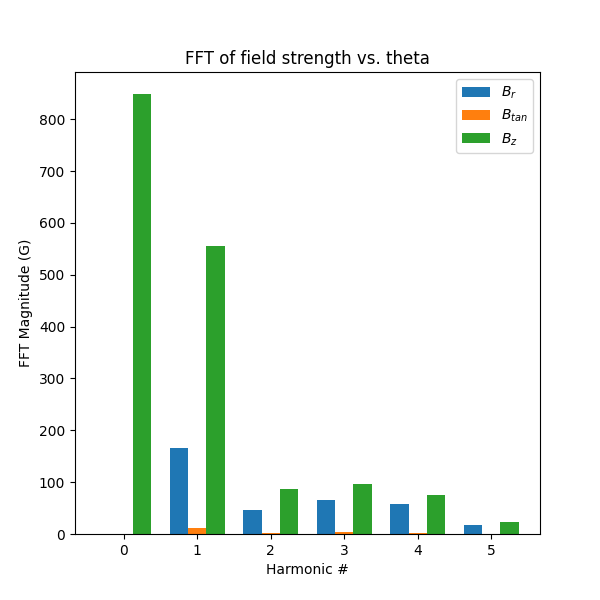

In [252]:
# run a fft on the field strength vs theta
fft_r = np.fft.fft(field_r, norm='forward')
fft_tan = np.fft.fft(field_tan, norm='forward')
fft_z = np.fft.fft(field_z, norm='forward')
freq = np.fft.fftfreq(theta.shape[0], d=theta[1]-theta[0])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

max_interest = 5 #fft_r.shape[0]//2

ax.bar([i-0.25 for i in range(max_interest+1)], np.abs(fft_r)[:max_interest+1], 0.25, label='$B_r$')
ax.bar([i for i in range(max_interest+1)], np.abs(fft_tan)[:max_interest+1], 0.25, label='$B_{tan}$')
ax.bar([i+0.25 for i in range(max_interest+1)], np.abs(fft_z)[:max_interest+1], 0.25, label='$B_z$')
ax.set_title('FFT of field strength vs. theta')
ax.set_ylabel('FFT Magnitude (G)')
ax.set_xlabel('Harmonic #')
ax.legend()

## Notes on Below Plots
- For ideal coil layout, $B_{tan}$ should be zero, deviates depending on resolution of coil simulated
    - Expected deviation can be approximated by $\text{max}(B_{tan})=-1.096+\frac{869.9}{\text{res}}$

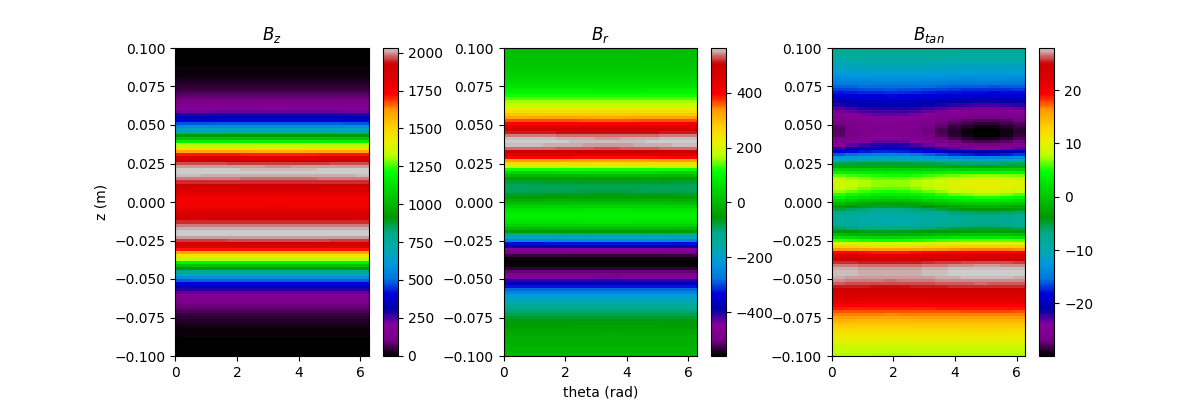

In [264]:
# plot field strength surface for z,r,tan fields
fig = plt.figure(figsize=(12,4))
ax1= fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)
#ax.imshow(field_strength[:,0,:] * 1e4)

aspect = 50

fig.colorbar(ax1.imshow(field_z.reshape(z_resolution,angle_resolution), cmap='nipy_spectral', extent=[0, math.tau, -z_dist/2, z_dist/2], aspect=aspect, origin='lower'), ax=ax1)
fig.colorbar(ax2.imshow(field_r.reshape(z_resolution,angle_resolution), cmap='nipy_spectral', extent=[0, math.tau, -z_dist/2, z_dist/2], aspect=aspect, origin='lower'), ax=ax2)
fig.colorbar(ax3.imshow(field_tan.reshape(z_resolution,angle_resolution), cmap='nipy_spectral', extent=[0, math.tau, -z_dist/2, z_dist/2], aspect=aspect, origin='lower'), ax=ax3)

ax2.set_xlabel('theta (rad)')
ax1.set_ylabel('z (m)')
ax1.set_title('$B_z$')
ax2.set_title('$B_r$')
ax3.set_title('$B_{tan}$');

$B_z$ max deviation:  8.21 G at z =  0.02323
$B_r$ max deviation:  7.59 G at z =  0.03939
$B_{tan}$ min deviation:  0.08 G at z =  -0.1
8.210900240274668


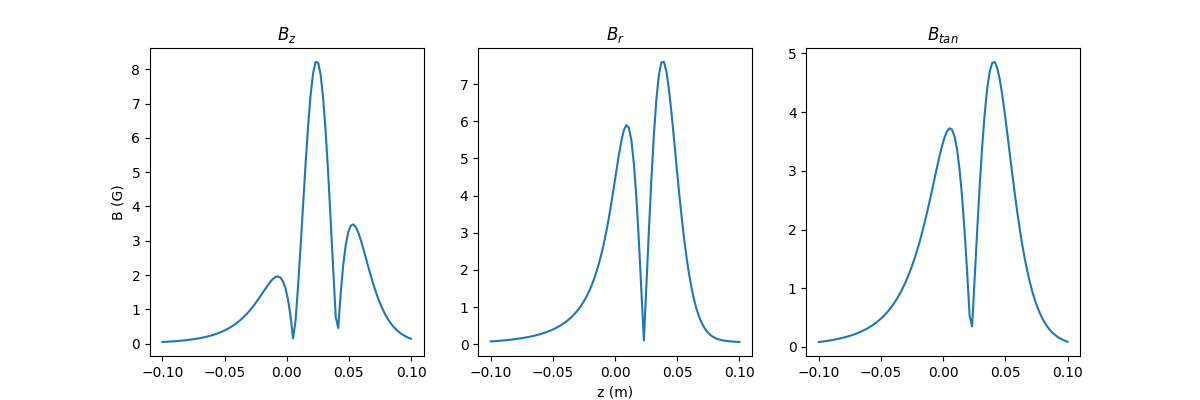

In [254]:
fig = plt.figure(figsize=(12,4))
ax1= fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)

dev_z = np.max(field_z.reshape(z_resolution,angle_resolution), axis=1) - np.min(field_z.reshape(z_resolution,angle_resolution), axis=1)
dev_r = np.max(field_r.reshape(z_resolution,angle_resolution), axis=1) - np.min(field_r.reshape(z_resolution,angle_resolution), axis=1)
dev_tan = np.max(field_tan.reshape(z_resolution,angle_resolution), axis=1) - np.min(field_tan.reshape(z_resolution,angle_resolution), axis=1)

ax1.plot(z[:,0,0], dev_z)
ax2.plot(z[:,0,0], dev_r)
ax3.plot(z[:,0,0], dev_tan)

ax2.set_xlabel('z (m)')
ax1.set_ylabel('B (G)')
ax1.set_title('$B_z$')
ax2.set_title('$B_r$')
ax3.set_title('$B_{tan}$')

print('$B_z$ max deviation: ', round(np.max(dev_z),2), 'G at z = ', round(z[np.argmax(dev_z),0,0],5))
print('$B_r$ max deviation: ', round(np.max(dev_r),2), 'G at z = ', round(z[np.argmax(dev_r),0,0],5))
print('$B_{tan}$ min deviation: ', round(np.min(dev_tan),2), 'G at z = ', round(z[np.argmin(dev_tan),0,0],5))

print(np.max(dev_z))

In [255]:
solb_real = np.array([5.656,5.646,5.660,5.658,5.629,5.607,5.567,5.589,5.604,5.657,5.661,5.684,5.657])*10

31.153345310813386


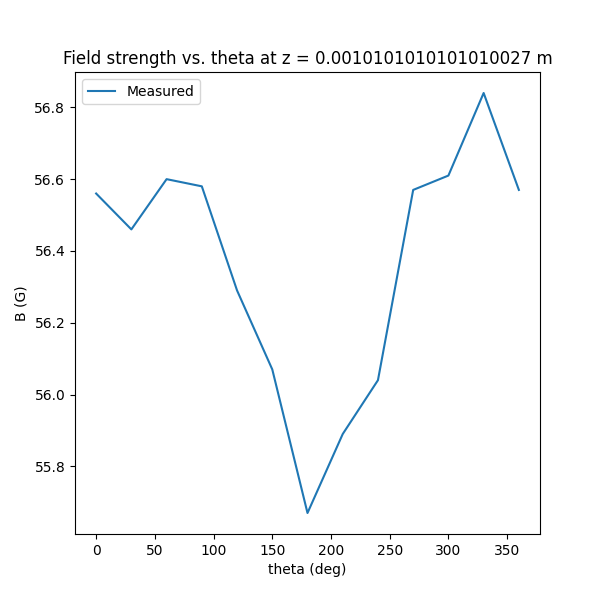

In [256]:
z_slice = z_resolution//2
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.plot(np.linspace(0,360,12+1, endpoint=True), solb_real, label='Measured')
#ax.plot(np.linspace(0,360,12, endpoint=False), field_z.reshape(z_resolution,angle_resolution)[z_slice,:], label='Simulated')
ax.set_xlabel('theta (deg)')
ax.set_ylabel('B (G)')
ax.set_title('Field strength vs. theta at z = ' + str(z[z_slice,0,0]) + ' m')
ax.legend();

slice_dif = solb_real.mean() / field_z.reshape(z_resolution,angle_resolution)[z_slice,:].mean()
print(1/slice_dif)

In [257]:
# fit a sine wave to the average field strength
def wave(x, a, c, d):
    return a**2 * np.sin(x + c) + d

In [258]:
# FOR SOLENOID / SHIELD 1 POSITION (ONLY ONE PAIR AT A TIME)
popt_z, pcov_z = curve_fit(wave, np.linspace(0,2*np.pi, angle_resolution, endpoint=False), field_z.reshape(z_resolution,angle_resolution).mean(axis=0), p0=[.1, 0.5, 468])
popt_r, pcov_r = curve_fit(wave, np.linspace(0,2*np.pi, angle_resolution, endpoint=False), field_r.reshape(z_resolution,angle_resolution).mean(axis=0), p0=[0.1,1,63.7])

angle_z = 4.71238898 - popt_z[1]
#angle_r = 6.0236375258 - popt_r[1]
angle_guess = angle_z # 0.5 * (angle_z + angle_r)

rdev_z = np.max(dev_z) / 30399.624984956077
rdev_r = np.max(dev_r) / 10435.60423510173
rdev_tan = np.max(dev_tan) / 40284.15401407412
rdev_guess = rdev_z #(rdev_z + rdev_r + rdev_tan) / 3

xy_guess = np.array([rdev_guess * np.cos(angle_guess), rdev_guess * np.sin(angle_guess)])
print(xy_guess*1000)

[-2.70098735e-01  5.36043227e-08]


In [259]:
dev_rz = solb_real.max() - solb_real.min()
popt_rz, pcov_rz = curve_fit(wave, np.linspace(0,2*np.pi, 12, endpoint=True), solb_real[:-1], p0=[dev_rz/2, 0.5, 5.65])

angle_rz = 4.71238898 - popt_rz[1]
rdev_rz = dev_rz / 10435.60423510173

mag_err = 1 # gauss
xy_rz = np.array([rdev_rz * np.cos(angle_rz), rdev_rz * np.sin(angle_rz)])
print("predicted xy offset:", xy_rz*1000)
print("offset magnitude:", np.linalg.norm(xy_rz)*1000, "mm ±", 2*mag_err*1000/10435.604)

print((dev_rz + 2 * mag_err)/10435.60423510173 *1000)
print((dev_rz - 2 * mag_err)/10435.60423510173 *1000)
print(angle_rz*180/np.pi)

predicted xy offset: [-0.10332644 -0.04351647]
offset magnitude: 0.11211617206261332 mm ± 0.19165158049308886
0.3037677482380204
-0.07953540411279378
202.8386485625027


In [260]:
# aligned_field_strength = field_strength[:,0,:]

NameError: name 'aligned_field_strength' is not defined

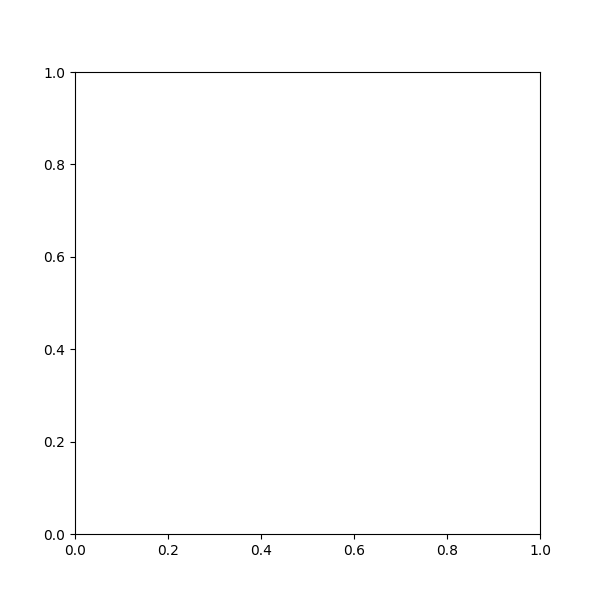

In [261]:
# plot field strength surface
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
#ax.imshow(field_strength[:,0,:])
fig.colorbar(ax.imshow(field_strength[:,0,:] - aligned_field_strength, cmap='coolwarm', extent=[0, math.tau, -z_dist/2, z_dist/2], aspect=100, origin='lower'), ax=ax)

ax.set_xlabel('theta (rad)')
ax.set_ylabel('z (m)')
ax.set_title('Difference in field strength (G)\n between aligned and unaligned solenoids')